In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from urllib.request import urlopen
from netCDF4 import Dataset
import requests
from io import BytesIO
import dask
import cmocean
import calendar
import seaborn as sns

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config['data_dir'] = os.getenv('CARTOPY_DIR', cartopy.config.get('data_dir'))

from matplotlib import pyplot as plt
#%config InlineBackend.figure_format = 'retina'
plt.ion()  # To trigger the interactive inline mode

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [2]:
url="https://icdc.cen.uni-hamburg.de/thredds/dodsC/reynolds_sst_all"
ds = xr.open_dataset(url)
ds

<xarray.Dataset>
Dimensions:               (lat: 720, lon: 1440, time: 505)
Coordinates:
  * lat                   (lat) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
  * lon                   (lon) float32 0.125 0.375 0.625 ... 359.4 359.6 359.9
  * time                  (time) datetime64[ns] 1981-09-15 ... 2023-09-15
Data variables:
    sst                   (time, lat, lon) float32 ...
    min_sea_ice_extent    (time, lat, lon) int8 ...
    max_sea_ice_extent    (time, lat, lon) int8 ...
    sst_mean_uncertainty  (time, lat, lon) float32 ...
    sst_stddev            (time, lat, lon) float32 ...
    n_days                (time, lat, lon) int16 ...
Attributes: (12/29)
    Conventions:                CF-1.6
    title:                      Monthly-OISST-v02r01_UHAM-ICDC_v01 from NOAA/...
    references:                 Reynolds, et al.(2007) Daily High-Resolution-...
    institution:                University of Hamburg/CEN/ICDC,original:NOAA/...
    contact:                    Dick Reynolds; Chunying Liu; Viva Banzon: ois...
    creation_date:              2023-10-30 10:00
    ...                         ...
    time_coverage_duration:     P42Y
    time_coverage_resolution:   P1M
    source_data:                Daily oisst-avhrr-v02r01.YYYYMMDD.nc, HadISST...
    comment:                    Computation of monthly mean SST from Daily_OI...
    history:                    Wed Jan 10 17:13:02 2024: ncatted -O -a _Fill...
    NCO:                        netCDF Operators version 4.9.2 (Homepage = ht...

In [3]:
# clip by coordinates (x,y)

min_lon = 153.06     # lower left longitude
min_lat = -18.26     # lower left latitude
max_lon = 154.27     # upper right longitude
max_lat = -17.2     # upper right latitude

# Defining the boundaries
lon_bnds = [min_lon, max_lon]
lat_bnds = [min_lat, max_lat]

# Performing the reduction
ds_clip = ds.sel(lat=slice(*lat_bnds), lon=slice(*lon_bnds))
ds_clip

<xarray.Dataset>
Dimensions:               (lat: 4, lon: 5, time: 505)
Coordinates:
  * lat                   (lat) float32 -18.12 -17.88 -17.62 -17.38
  * lon                   (lon) float32 153.1 153.4 153.6 153.9 154.1
  * time                  (time) datetime64[ns] 1981-09-15 ... 2023-09-15
Data variables:
    sst                   (time, lat, lon) float32 ...
    min_sea_ice_extent    (time, lat, lon) int8 ...
    max_sea_ice_extent    (time, lat, lon) int8 ...
    sst_mean_uncertainty  (time, lat, lon) float32 ...
    sst_stddev            (time, lat, lon) float32 ...
    n_days                (time, lat, lon) int16 ...
Attributes: (12/29)
    Conventions:                CF-1.6
    title:                      Monthly-OISST-v02r01_UHAM-ICDC_v01 from NOAA/...
    references:                 Reynolds, et al.(2007) Daily High-Resolution-...
    institution:                University of Hamburg/CEN/ICDC,original:NOAA/...
    contact:                    Dick Reynolds; Chunying Liu; Viva Banzon: ois...
    creation_date:              2023-10-30 10:00
    ...                         ...
    time_coverage_duration:     P42Y
    time_coverage_resolution:   P1M
    source_data:                Daily oisst-avhrr-v02r01.YYYYMMDD.nc, HadISST...
    comment:                    Computation of monthly mean SST from Daily_OI...
    history:                    Wed Jan 10 17:13:02 2024: ncatted -O -a _Fill...
    NCO:                        netCDF Operators version 4.9.2 (Homepage = ht...

In [9]:
# Isolate the time dimension and remove lat and lon dimensions
ds_time_only = ds_clip.isel(lat=0, lon=0).drop(['lat', 'lon'])

In [10]:
print(ds_time_only)

<xarray.Dataset>
Dimensions:               (time: 505)
Coordinates:
  * time                  (time) datetime64[ns] 1981-09-15 ... 2023-09-15
Data variables:
    sst                   (time) float32 ...
    min_sea_ice_extent    (time) int8 ...
    max_sea_ice_extent    (time) int8 ...
    sst_mean_uncertainty  (time) float32 ...
    sst_stddev            (time) float32 ...
    n_days                (time) int16 ...
Attributes: (12/29)
    Conventions:                CF-1.6
    title:                      Monthly-OISST-v02r01_UHAM-ICDC_v01 from NOAA/...
    references:                 Reynolds, et al.(2007) Daily High-Resolution-...
    institution:                University of Hamburg/CEN/ICDC,original:NOAA/...
    contact:                    Dick Reynolds; Chunying Liu; Viva Banzon: ois...
    creation_date:              2023-10-30 10:00
    ...                         ...
    time_coverage_duration:     P42Y
    time_coverage_resolution:   P1M
    source_data:                Daily o

In [11]:
# Group by month
grouped_data = ds_time_only.groupby('time.month')

# Calculate the mean SST for each month
monthly_mean_sst = grouped_data.mean(dim='time')

# Now, monthly_mean_sst contains the averaged SST per month throughout the years

In [12]:
print(monthly_mean_sst)

<xarray.Dataset>
Dimensions:               (month: 12)
Coordinates:
  * month                 (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst                   (month) float32 301.3 301.5 301.1 ... 299.7 300.7
    min_sea_ice_extent    (month) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    max_sea_ice_extent    (month) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    sst_mean_uncertainty  (month) float32 0.1817 0.186 0.1826 ... 0.1593 0.1669
    sst_stddev            (month) float32 0.5488 0.481 0.5421 ... 0.5198 0.5929
    n_days                (month) float64 31.0 28.0 31.0 30.0 ... 31.0 30.0 31.0
Attributes: (12/29)
    Conventions:                CF-1.6
    title:                      Monthly-OISST-v02r01_UHAM-ICDC_v01 from NOAA/...
    references:                 Reynolds, et al.(2007) Daily High-Resolution-...
    institution:                University of Hamburg/CEN/ICDC,original:NOAA/...
    contact:                    Dick Reynolds; Chunying Liu; Viva Banzon: 

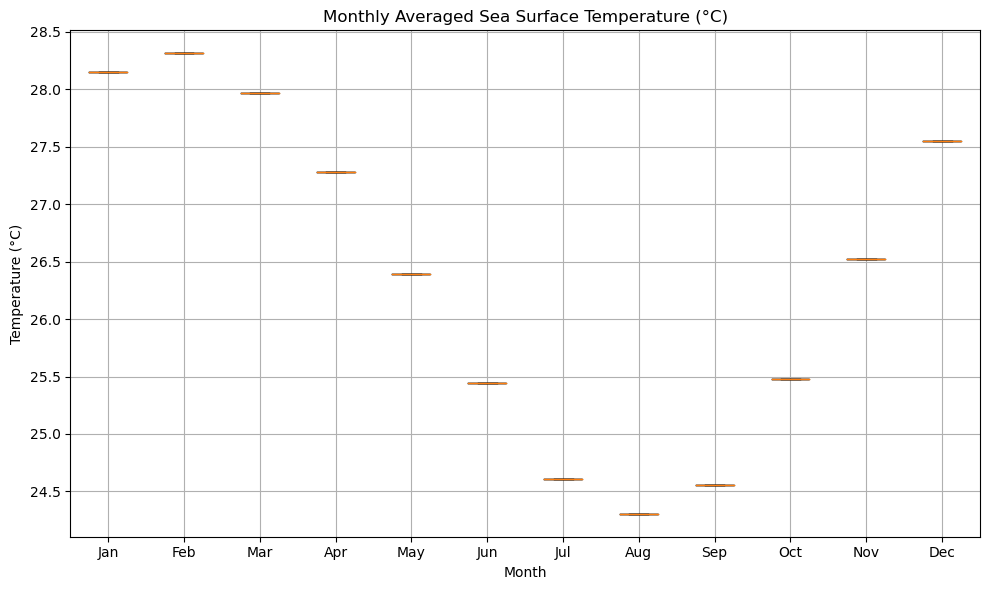

In [13]:
# create a box plot with months on x-axis and sst on y-axis 

# Convert Kelvin to Celsius for each SST value in the monthly_temperatures_array
monthly_temperatures_array_celsius = [
    (monthly_mean_sst.sel(month=month).sst.values - 273.15).flatten() for month in range(1, 13)
]

# Create the box plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(monthly_temperatures_array_celsius)

# Set labels and title
ax.set_xticklabels(calendar.month_abbr[1:])
ax.set_xlabel('Month')
ax.set_ylabel('Temperature (°C)')
ax.set_title('Monthly Averaged Sea Surface Temperature (°C)')

plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
reef_lat = -17.401
reef_lon = 155.868

In [ ]:
# create a map with sst and reef location
# Figure size
size = (9, 10)

# Color from cmocean
color = cmocean.cm.balance

# Defining the figure
fig = plt.figure(figsize=size, facecolor='w', edgecolor='k')

# Axes with Cartopy projection
ax = plt.axes(projection=ccrs.PlateCarree())
# and extent
ax.set_extent([153.06, 154.27, -17.2, -18.26], ccrs.PlateCarree())

# Plotting using Matplotlib 
# We plot the Temp at the surface at the final recorded time interval

# cf = ds_clip.sst.isel(time=time,k=-1).plot(
#    transform=ccrs.PlateCarree(), cmap=color,
#    vmin = 22, vmax = 32,
#    add_colorbar=False
#)

# Plotting the SST data
cf = ds.sst.plot(
    transform=ccrs.PlateCarree(),
    cmap='coolwarm',  # Specify the colormap
    vmin=22,          # Minimum value for color mapping
    vmax=32,          # Maximum value for color mapping
    add_colorbar=False  # Do not add a colorbar
)

# Color bar
cbar = fig.colorbar(cf, ax=ax, fraction=0.027, pad=0.045, orientation="horizontal")
cbar.set_label(ds_clip.temp.long_name+' '+ds_clip.temp.units, rotation=0, 
               labelpad=5, fontsize=10)
cbar.ax.tick_params(labelsize=8)

# Title
plt.title('Sea Surface Temperature (C) on ' +str(ds_clip.coords['time'].values[day])[:10],
          fontsize=11
         )

# Plot lat/lon grid 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8} 

# Add map features with Cartopy 
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', 
                                            edgecolor='face', 
                                            facecolor='lightgray'))

ax.coastlines(linewidth=1)

# Site Mellish reef 
ax.scatter(reef_lon, reef_lat, c='deeppink', s=50, edgecolors='k', linewidth=1, transform=ccrs.PlateCarree())

plt.tight_layout()
plt.show()
fig.clear()
plt.close(fig)
plt.clf()

In [ ]:
month_st = 1   # Starting month 
month_ed = 3   # Ending month 
year = 2018    # Year

# Based on the server the file naming convention 
biofiles = [f"{base_url}{year}-{month:02}.nc" for month in range(month_st, month_ed+1)]
hydrofiles = [f"{base_url2}{year}-{month:02}.nc" for month in range(month_st, month_ed+1)]
biofiles

# use chatGPT to make a new code, based on this one, that will loop throught the years and output nonthly averaged for 10 years 
# without the need to input eah year (like in this code)